In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns
import torch.nn as nn
import torch
import os
#import math
#import pandas as pd
#from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
import pickle
import torchvision
from torch.optim import SGD, Adam
from crp.image import imgify, vis_opaque_img, plot_grid
from random import random

#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
#from torch.autograd import Variable

from tqdm import tqdm 
from PIL import Image
import numpy as np

import tigramite
from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [6]:
from shape_covnet import ShapeConvolutionalNeuralNetwork, train_network
from causal_dsprites_dataset import get_datasets, CausalDSpritesDataset

In [7]:
BATCH_SIZE = 128

training_loader, test_loader, dsprites_dataset = get_datasets(BATCH_SIZE)

In [8]:
model = train_network(training_loader, BATCH_SIZE, load=False, path="causal_dsprites.pickle")

EPOCH 1:


  batch 1700 correct 50.01%: : 1729it [01:04, 26.98it/s]


EPOCH 2:


  batch 1700 correct 50.41%: : 1729it [01:24, 20.57it/s]


EPOCH 3:


  batch 1700 correct 50.53%: : 1729it [01:27, 19.68it/s]


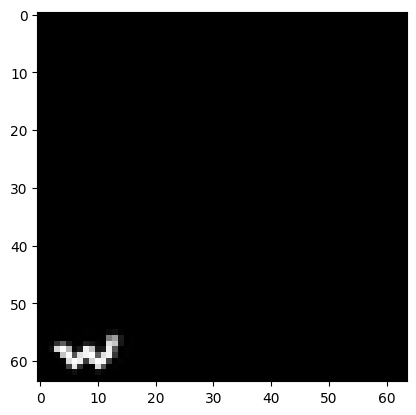

In [4]:


im_frame = Image.open( 'pxArt.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = vals.view(1,64,64)
w = np.where(vals <= 100)
plt.imshow(vals[0], cmap="Greys")

In [9]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

fv_path = "crp-stuff/dsprites-causal"
fv = FeatureVisualization(attribution, dsprites_dataset, layer_map, path=fv_path)
layer_names

['convolutional_layers.0',
 'convolutional_layers.3',
 'linear_layers.0',
 'linear_layers.2']

In [10]:
# it will take approximately 20 min on a Titan RTX
# run this only if you want to regenerate all the reference images visualizations
saved_files = fv.run(composite, 0, len(dsprites_dataset), 20, 100)

Running Analysis...


100%|██████████| 36864/36864 [25:02<00:00, 24.53it/s]


100%|██████████| 4428/4428 [00:03<00:00, 1110.30it/s]


In [11]:
from crp.cache import ImageCache

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="causal-dsprites-cache")

fv = FeatureVisualization(attribution, dsprites_dataset, layer_map, path=fv_path, cache=cache)
from crp.helper import get_output_shapes
import numpy as np

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=False,alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Layer: convolutional_layers.3


100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


Layer: linear_layers.0


100%|██████████| 8/8 [00:01<00:00,  6.77it/s]


Layer: linear_layers.2


100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


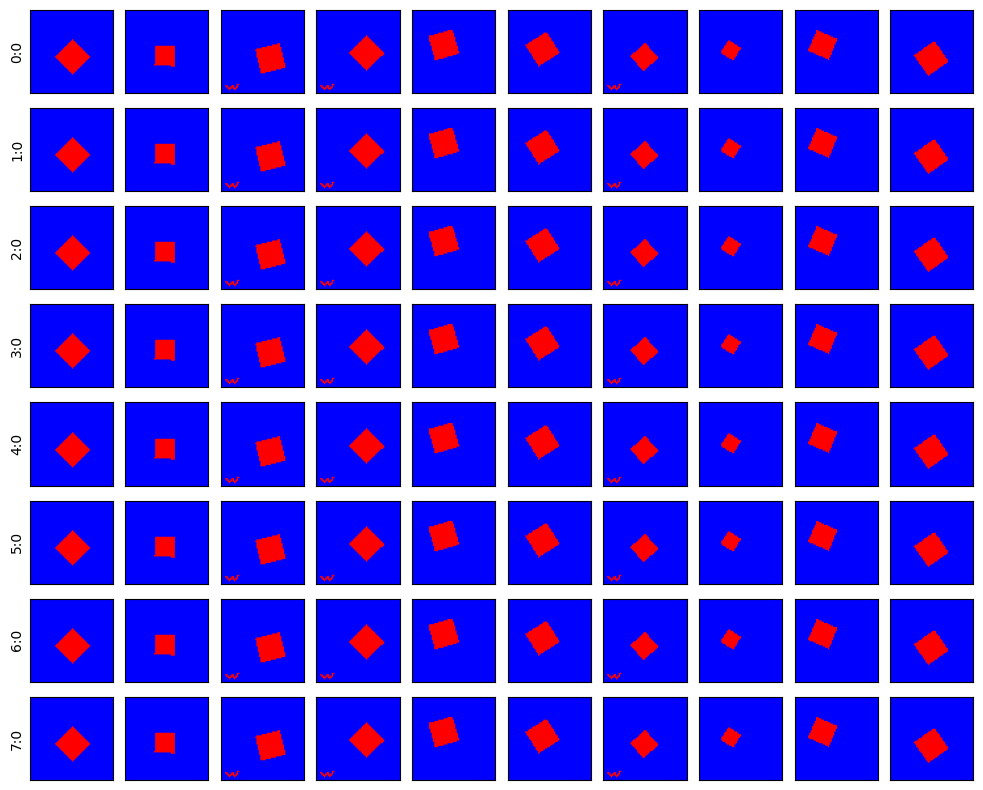

In [12]:
def make_all_relevances(cond_layer, neurons):
    all_refs = {}
    for i in neurons:
        targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
        ref_c = fv.get_stats_reference(
            i,
            cond_layer,
            [targets],
            "relevance",
            (0, 10),
            composite=composite,
            rf=True,
            plot_fn=vis_opaque_img,
        )
        all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
    plot_grid(all_refs, figsize=(10, len(neurons)), padding=False, symmetric=True)


make_all_relevances("convolutional_layers.0", range(8))

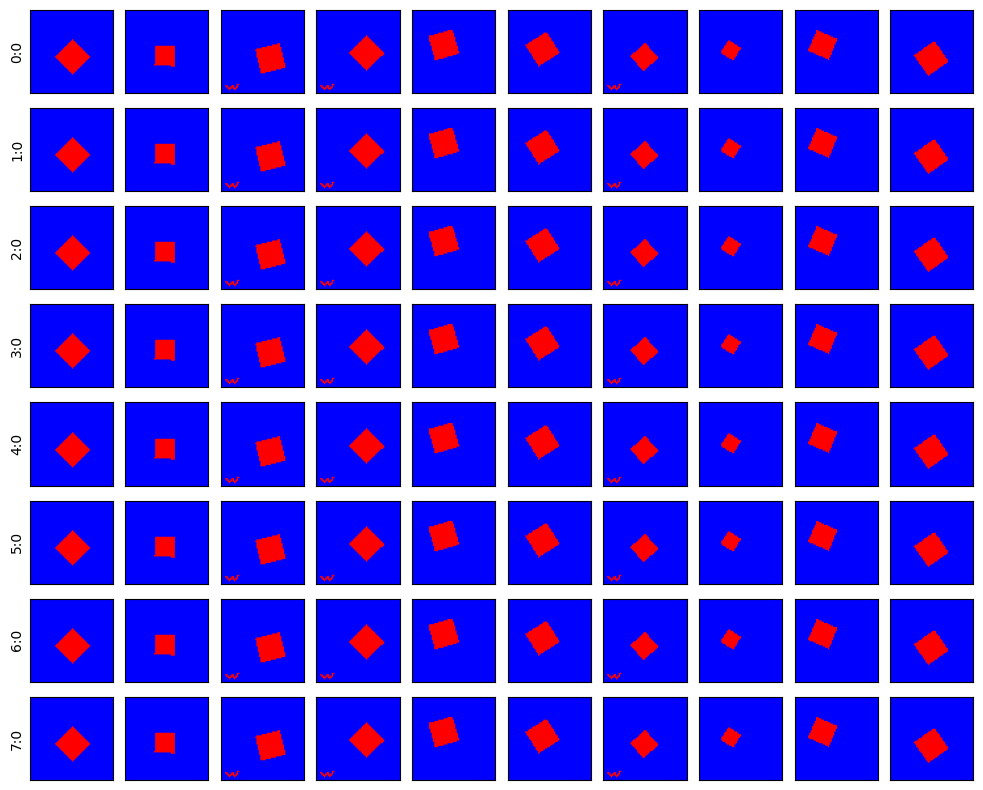

In [13]:
make_all_relevances("convolutional_layers.3",range(8))

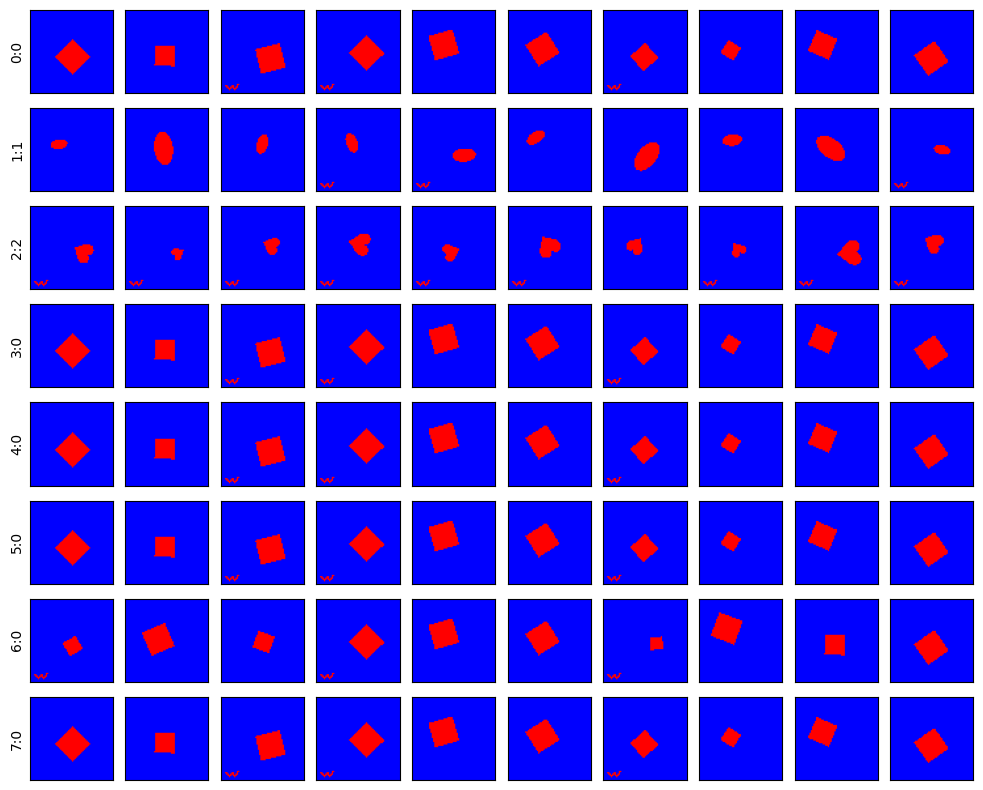

In [14]:
make_all_relevances("linear_layers.0",range(8))

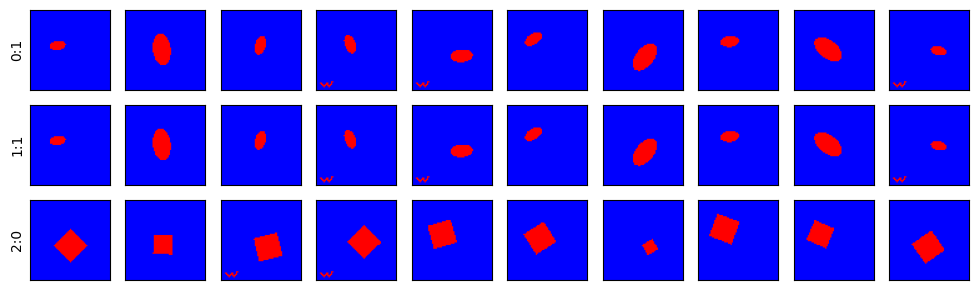

In [15]:
make_all_relevances("linear_layers.2", range(3))

label 1,prediction:1 top 6 concepts: tensor([5, 3, 7, 6, 4, 1]), their relevances: tensor([43.8743, 22.1110, 17.4561, 12.1557,  2.2519,  0.1216])


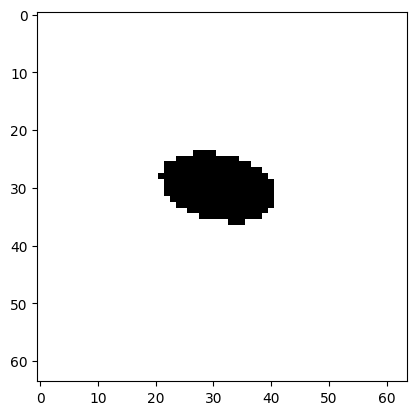

In [14]:
index = 20
datum = dsprites_dataset[index]
label = datum[1]
img = datum[0]
sample = img.view(1,1,64,64)
sample.requires_grad = True
cond_layer = 'convolutional_layers.3'

conditions = [{'y': [label]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
pred = attr.prediction.max(1, keepdim=True)[1]

rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
# the ten most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(f'label {label},prediction:{pred[0][0]} top 6 concepts: {concept_ids}, their relevances: {rel_values*100}')
#conditions = [{cond_layer: [id], 'y': [label]} for id in concept_ids]
#heatmap, a, b, c = attribution(sample, conditions, composite)
#imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)),resize=700)
plt.imshow(img[0], cmap="Greys")

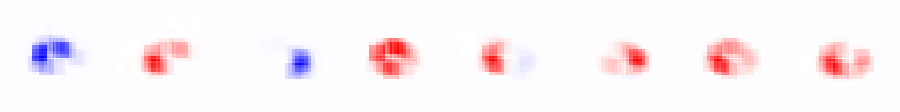

In [12]:
cond_layer,n_c = "convolutional_layers.3",8
start_layer,n_s = "linear_layers.0",8

conditions = [
    {"y": [label], cond_layer: [j]}  for j in range(n_c)
] 
attr = attribution(
    sample,
    conditions,
    composite,
    record_layer=layer_names,
)

imgify(attr.heatmap, resize=900, grid=(1, n_c), symmetric=True)
